# Lab CMBLenses

## Model

In [1]:
] activate "/home/jaimerz/julia_repos/CMBLensingInferenceTestProblem"

  Activating project at `~/julia_repos/CMBLensingInferenceTestProblem`


In [2]:
using CMBLensing, CMBLensingInferenceTestProblem
using CUDA, LaTeXStrings, MCMCDiagnosticTools, Plots, ProgressMeter, Random, Zygote
using LinearAlgebra, Statistics
ENV["LINES"] = 10;

[ Info: Precompiling CMBLensing [b60c06c0-7e54-11e8-3788-4bd722d65317]
[ Info: Precompiling CMBLensingInferenceTestProblem [77eb751d-b138-43db-8fbb-26307a053bc2]
[ Info: Precompiling CUDA [052768ef-5323-5732-b1bb-66c8b64840ba]
[ Info: Precompiling MCMCDiagnosticTools [be115224-59cd-429b-ad48-344e309966f0]
[ Info: Precompiling Plots [91a5bcdd-55d7-5caf-9e0b-520d859cae80]
[ Info: GR


In [3]:
using Revise
using MCHMC

[ Info: Precompiling MCHMC [92da4d09-9da0-4f8a-8b31-da41ef0ab6ee]


In [4]:
prob = load_cmb_lensing_problem(storage = Array,
                                T = Float32,
                                Nside = 4);

MAP_joint: 100%|████████████████████████████████████████| Time: 0:00:48
  step:        20
  logpdf:      377.00
  α:           0.008522608
  CG:          2 iterations
  Linesearch:  9 bisections


In [5]:
CMBLensingTarget2(prob; kwargs...) = begin
    d = length(prob.Ωstart)
    Λmass = real(prob.Λmass)
    sqrtΛmass = sqrt(Λmass)
    inv_sqrtΛmass = pinv(sqrtΛmass)

    function transform(x)
        xt = x
        xt = CMBLensing.LenseBasis(inv_sqrtΛmass * x)
        #xt = CMBLensing.LenseBasis(sqrtΛmass * x)
        return xt
    end

    function inv_transform(xt)
        x = xt
        x = CMBLensing.LenseBasis(sqrtΛmass * xt)
        #x = CMBLensing.LenseBasis(inv_sqrtΛmass * xt)
        return x
    end

    function nlogp(xt)
        x = inv_transform(xt)
        return  -1.0 .* prob(x)
    end

    function grad_nlogp(xt)
        return CMBLensing.LenseBasis(Zygote.gradient(nlogp, xt)[1])
        #return ForwardDiff.gradient(nlogp, x)
    end

    function prior_draw(key)
        x = prob.Ωstart
        xt = transform(x)
        return CMBLensing.LenseBasis(xt)
        #return prob.Ωstart
    end

    CMBLensingTarget(d,
                     Λmass,
                     nlogp,
                     grad_nlogp,
                     transform,
                     inv_transform,
                     prior_draw)
end

CMBLensingTarget2 (generic function with 1 method)

In [6]:
CMBLensingTarget3(prob; kwargs...) = begin
    d = length(prob.Ωstart)
    Λmass = real(prob.Λmass)
    sqrtΛmass = sqrt(Λmass)
    inv_sqrtΛmass = pinv(sqrtΛmass)

    function transform(x)
        xt = x
        #xt = CMBLensing.LenseBasis(inv_sqrtΛmass * x)
        xt = CMBLensing.LenseBasis(sqrtΛmass * x)
        return xt
    end

    function inv_transform(xt)
        x = xt
        #x = CMBLensing.LenseBasis(sqrtΛmass * xt)
        x = CMBLensing.LenseBasis(inv_sqrtΛmass * xt)
        return x
    end

    function nlogp(xt)
        x = inv_transform(xt)
        return -1.0 .* prob(x)
    end

    function grad_nlogp(xt)
        return CMBLensing.LenseBasis(Zygote.gradient(nlogp, xt)[1])
        #return ForwardDiff.gradient(nlogp, x)
    end

    function prior_draw(key)
        x = prob.Ωstart
        xt = transform(x)
        return CMBLensing.LenseBasis(xt)
        #return prob.Ωstart
    end

    CMBLensingTarget(d,
                     Λmass,
                     nlogp,
                     grad_nlogp,
                     transform,
                     inv_transform,
                     prior_draw)
end

CMBLensingTarget(50, [0.0 0.0 … 0.0 0.0; 0.0 4.224938869476318 … 0.0 0.0; … ; 0.0 0.0 … 1.0 0.0; 0.0 0.0 … 0.0 1.0], MCHMC.var"#nlogp#84"{CMBLensingInferenceTestProblem.CMBLensingLogDensityProblem, MCHMC.var"#inv_transform#83"{Diagonal{Float64, Field-(f°,ϕ°,θ)-Tuple{LambertEBFourier{Array{Float32, 3}}, LambertFourier{Array{Float32, 2}}, ComponentArrays.ComponentVector{Float64, Vector{Float64}, Tuple{ComponentArrays.Axis{(r = 1, Aϕ = 2)}}}}}}}(CMBLensingInferenceTestProblem.CMBLensingLogDensityProblem(BaseDataSet(d, Cf, Cn, Cn̂, M, M̂, B, B̂, logprior, Cϕ, Cf̃, D, G, L, Nϕ), [0.23362982273101807, 1.6145217418670654, -1.8872356414794922, -3.2767221927642822, 0.8644531965255737, 2.2458934783935547, -1.246073603630066, -2.639155864715576, 1.868626356124878, 3.251345157623291  …  -3.395840053599386e-9, 3.6597669339499816e-11, 4.677404241704153e-9, 1.211756028851596e-9, -5.810230518932258e-9, -2.3360031686792126e-9, 2.561251877253312e-9, -9.142808177209361e-10, -1.6094379124341003, 0.0], [0.

In [7]:
target = CMBLensingTarget2(prob);
target2 = CMBLensingTarget3(prob);

## Sample

In [8]:
eps=0.05
L=sqrt(target.d)*0.005
spl=Sampler(;eps=eps, L=L)

Sampler(Settings(MersenneTwister(0), 0.05, 0.035355339059327376, 0.0, 0.1931833275037836, 0.0005, 2000, 1000, 10, "LF"), MCHMC.Leapfrog)

In [9]:
samples = Sample(spl, target, 500, monitor_energy=true)

[0.031977344304323196, -0.0697084292769432, 0.06363599747419357, 0.027968456968665123, 0.15098969638347626, 0.08012367784976959, -0.34497344493865967, -0.08839288353919983, 0.0066175078973174095, 0.034835077822208405, -0.026745084673166275, 0.16648943722248077, -0.04674700275063515, -0.053186021745204926, -0.2676003575325012, 0.31748637557029724, 0.12181506305932999, 0.05305158346891403, -0.11302567273378372, -0.008793397806584835, 0.22366869449615479, -0.12506374716758728, -0.0627596527338028, 0.19879184663295746, 0.030698848888278008, -0.03823211416602135, 0.13085632026195526, 0.16451844573020935, -0.20756034553050995, -0.03834928944706917, -0.22425837814807892, -0.16429609060287476, -0.048626530915498734, -0.03706875443458557, 0.12417296320199966, 0.03699865564703941, -0.13681799173355103, -0.152242973446846, -0.04779578745365143, -0.09236222505569458, 0.236475870013237, 0.005181766115128994, 0.21782320737838745, 0.15159112215042114, 0.024807875975966454, -0.041524164378643036, 0.05

Row,Ω,Energy
,Any,Any
1,"[0.240736, 1.62163, -1.88013, -3.26962, 0.87156, 2.253, -1.23897, -2.63205, 1.87573, 3.25845 … -3.39584e-9, 3.65977e-11, 4.6774e-9, 1.21176e-9, -5.81023e-9, -2.336e-9, 2.56125e-9, -9.14281e-10, -1.60944, 0.0]",376.858
2,"[0.241056, 1.62034, -1.87709, -3.26861, 0.875661, 2.25644, -1.24983, -2.63521, 1.8749, 3.26039 … -3.2191e-9, 1.25077e-10, 4.94562e-9, 1.50348e-9, -5.77078e-9, -2.29076e-9, 2.75257e-9, -7.80868e-10, -1.60036, -0.0133961]",376.863
3,"[0.239934, 1.61988, -1.86915, -3.27022, 0.880572, 2.25889, -1.25414, -2.63449, 1.8739, 3.26234 … -3.1344e-9, -5.62922e-12, 4.94273e-9, 1.67388e-9, -5.74703e-9, -2.27752e-9, 3.04959e-9, -4.42194e-10, -1.58561, -0.02886]",376.959
4,"[0.238028, 1.61568, -1.86942, -3.2748, 0.879717, 2.26542, -1.24783, -2.63344, 1.87157, 3.26111 … -3.19316e-9, -3.02892e-10, 4.77301e-9, 1.58527e-9, -5.66036e-9, -2.30164e-9, 3.02351e-9, -3.82437e-10, -1.57515, -0.0336646]",377.037
5,"[0.237655, 1.62165, -1.87035, -3.27764, 0.884469, 2.2701, -1.25223, -2.64376, 1.86943, 3.26215 … -2.99822e-9, 1.27206e-10, 4.8473e-9, 1.30797e-9, -5.61243e-9, -2.15773e-9, 2.71212e-9, -7.66664e-10, -1.56489, -0.0320086]",377.108
6,"[0.23586, 1.62048, -1.86711, -3.28205, 0.880608, 2.27902, -1.25585, -2.64293, 1.87539, 3.26226 … -2.57373e-9, 5.28434e-10, 4.78483e-9, 1.27382e-9, -5.27944e-9, -1.96808e-9, 2.39496e-9, -1.02778e-9, -1.55469, -0.0251964]",377.078
7,"[0.233338, 1.62169, -1.86949, -3.28656, 0.882213, 2.28768, -1.25151, -2.64568, 1.87292, 3.26326 … -2.43934e-9, 7.29837e-10, 4.71836e-9, 1.02713e-9, -5.32957e-9, -1.81995e-9, 2.40355e-9, -1.25706e-9, -1.55286, -0.023234]",376.973
8,"[0.228175, 1.61886, -1.86918, -3.28729, 0.884558, 2.28599, -1.25295, -2.6419, 1.87467, 3.26817 … -2.47119e-9, 8.68522e-10, 4.67418e-9, 8.49435e-10, -5.42884e-9, -1.6656e-9, 2.60764e-9, -1.31728e-9, -1.56272, -0.0293215]",376.91
9,"[0.226799, 1.61709, -1.87, -3.27953, 0.883204, 2.28286, -1.2563, -2.63663, 1.88031, 3.27035 … -2.4383e-9, 9.74557e-10, 4.81942e-9, 9.17789e-10, -5.43092e-9, -1.48537e-9, 2.702e-9, -1.35233e-9, -1.56432, -0.0418668]",376.981


In [10]:
using DataFrames
thin_samples = DataFrame(Ω=Any[], Energy=Any[])
for i in 1:20
    k = (i-1)*25+1
    sample = samples[k, :]
    push!(thin_samples, (sample.Ω, sample.Energy))
end        

50-element Field-(f°,ϕ°,θ)-Tuple{LambertQUMap{Array{Float32, 3}}, LambertMap{Array{Float32, 2}}, ComponentArrays.ComponentVector{Float64, Vector{Float64}, Tuple{ComponentArrays.Axis{(r = 1, Aϕ = 2)}}}}:
 -0.13743168115615845
  0.08669047057628632
 -0.10110758990049362
  ⋮
  0.02899473371219355
  0.020083847590149497

## Plotting

In [11]:
Plots.default(fmt=:png, dpi=120, size=(500,300), legendfontsize=10)

LoadError: DomainError with -3.622709200842247e7:
log1p will only return a complex result if called with a complex argument. Try log1p(Complex(x)).

In [12]:
rs = [Vector(sample)[end-1] for sample in samples.Ω]
Aϕs = [Vector(sample)[end] for sample in samples.Ω];

501-element Vector{Vector{Float64}}:
 [0.11817961931228638, 0.7882625460624695, -0.915061891078949, -1.5918281078338623, 0.4248858690261841, 1.0952790975570679, -0.601466178894043, -1.2807449102401733, 0.9124752283096313, 1.5836602449417114  …  -1.9049437464526233e-16, -4.2375006943213514e-18, 2.5941760438202236e-16, 7.301237393385877e-17, -3.152020031481085e-16, -1.306839356366479e-16, 1.3832532425629436e-16, -4.6198483888617374e-17, -1.6094379124341003, 0.0]
 [NaN, NaN, NaN, NaN, NaN, NaN, NaN, NaN, NaN, NaN  …  NaN, NaN, NaN, NaN, NaN, NaN, NaN, NaN, NaN, NaN]
 [NaN, NaN, NaN, NaN, NaN, NaN, NaN, NaN, NaN, NaN  …  NaN, NaN, NaN, NaN, NaN, NaN, NaN, NaN, NaN, NaN]
 ⋮
 [NaN, NaN, NaN, NaN, NaN, NaN, NaN, NaN, NaN, NaN  …  NaN, NaN, NaN, NaN, NaN, NaN, NaN, NaN, NaN, NaN]
 [NaN, NaN, NaN, NaN, NaN, NaN, NaN, NaN, NaN, NaN  …  NaN, NaN, NaN, NaN, NaN, NaN, NaN, NaN, NaN, NaN]

In [13]:
samples2 = Sample(spl, target2; num_steps=500)

501-element Vector{Vector{Float64}}:
 [0.49172186851501465, 3.3348827362060547, -3.8632519245147705, -6.717447280883789, 1.7892075777053833, 4.633310794830322, -2.5502521991729736, -5.4095892906188965, 3.8559768199920654, 6.702130317687988  …  -0.04988100752234459, -0.000928846187889576, 0.0768577978014946, 0.020462296903133392, -0.1136246994137764, -0.03365310654044151, 0.054052047431468964, -0.02620689570903778, -1.6094379124341003, 0.0]
 [0.24357629153937188, 1.6273464975872098, -1.8868315749592104, -3.269368220379051, 0.8847847985389296, 2.2335327231419524, -1.2456864989745826, -2.629396940112421, 1.8802043382011964, 3.258813319618712  …  -3.4294460867307743e-9, -3.754452269902428e-10, 4.8514808869394296e-9, 1.7185425479312378e-9, -6.188917734956234e-9, -2.6721773852648587e-9, 2.6502120825009234e-9, -8.716046416656191e-10, -1.6148136397212078, 0.01258354614833649]
 [0.24627933991664197, 1.6357034562409511, -1.8957320954100885, -3.269669162745375, 0.8978965566809376, 2.2153200827108

## Plotting

In [14]:
Plots.default(fmt=:png, dpi=120, size=(500,300), legendfontsize=10)

In [15]:
rs = [Vector(sample)[end-1] for sample in thin_samples.Ω]
Aϕs = [Vector(sample)[end] for sample in thin_samples.Ω];

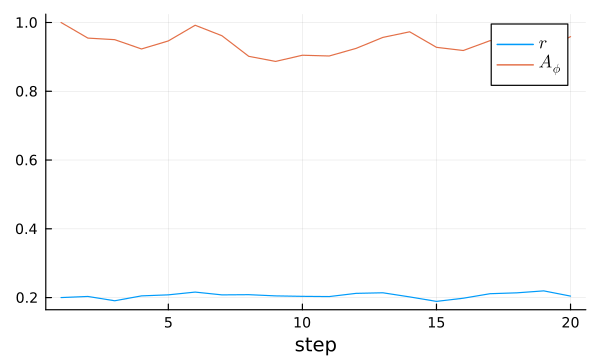

In [16]:
plot(exp.(rs), label=L"r", xlabel="step")
plot!(exp.(Aϕs), label=L"A_\phi")


In [17]:
println("Energy: ", mean(thin_samples.Energy), " -/+ ", std(thin_samples.Energy))

Energy: 376.51156662158803 -/+ 0.3376624656380899


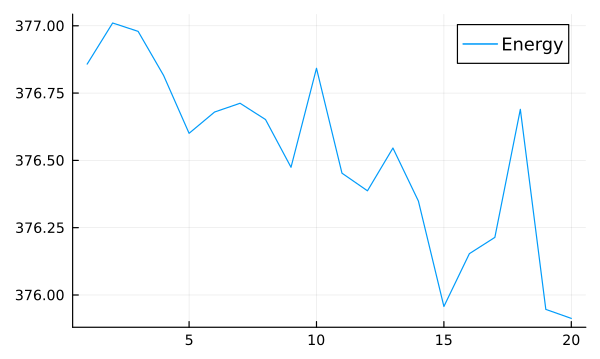

In [18]:
plot(exp.(rs), label=L"r", xlabel="step")
plot!(exp.(Aϕs), label=L"A_\phi")

In [19]:
rs = [sample[end-1] for sample in samples2]
Aϕs = [sample[end] for sample in samples2];

In [20]:
println(mean(exp.(rs)), " ", std(exp.(rs)))

1.3016734028474406 0.7914358036835447


In [21]:
println(mean(exp.(Aϕs)), " ", std(exp.(Aϕs)))

26.214009302860717 28.775959821312064


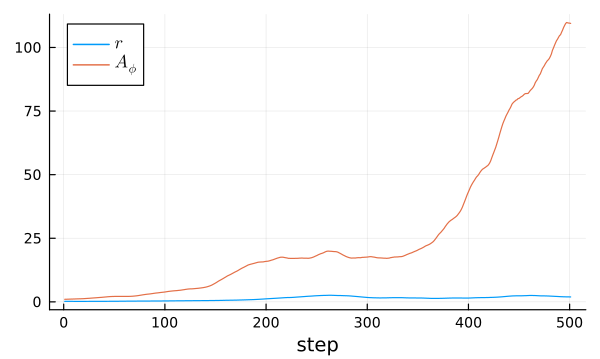

In [22]:
plot(exp.(rs), label=L"r", xlabel="step")
plot!(exp.(Aϕs), label=L"A_\phi")

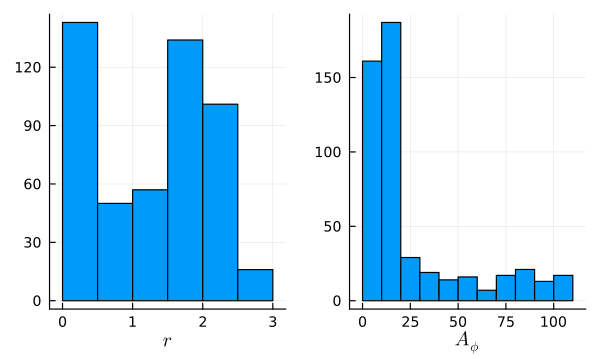

In [23]:
plot(histogram(exp.(rs), xlabel=L"r", label=nothing, lw=1),
    histogram(exp.(Aϕs), xlabel=L"A_\phi", label=nothing, lw=1))